# Probabilistic Machine Learning
<div style="text-align: right"> University of Tübingen, Summer Term 2023  &copy; 2023 P. Hennig </div>

## Exercise Sheet No. 8 — GP Classifiaction on Binary MNIST

---

Submission by:
* Sam Laing, Matrikelnummer: 6283670
* Albert Catalan, Matrikelnummer: 6443478

In [1]:
# Numpy, JAX
import jax
from jax import jit
import jax.numpy as jnp
import numpy as np
jax.config.update("jax_enable_x64", True)  # use double-precision numbers

In [2]:
# Plotting
from matplotlib import pyplot as plt
from tueplots import bundles

%config InlineBackend.figure_formats = ["svg"]
%matplotlib inline
plt.rcParams.update(bundles.neurips2023())

In [3]:
# Import `gaussians.py`
import gaussians

### 0. Overview

In this week's exercise, we will apply Gaussian Process (GP) classification to a subset of the [MNIST dataset](http://yann.lecun.com/exdb/mnist/). Your task is to set up the optimization problem, find the posterior mode, define the GP posterior, and perform some analyses on the results. 

### 1. Training and Test Data

The data has already been prepared for you: `X_train` and `X_test` contain 600 training and 600 test images of the digits 1 and 4. The pixel values are normalized to numbers between -1 and 1. The labels (`1` for the digit 1 and `-1` for the digit 4) for the training and test images are stored in `y_train` and `y_test`. 

In [4]:
# Load MNIST data
data = jnp.load("binary_MNIST.npz")

# Extract data
X_train, y_train = data["X_train"], data["y_train"]
X_test, y_test = data["X_test"], data["y_test"]

In [5]:
def print_data_info(X, y, title):
    print(f"\n{title}:")
    print("X.shape = ", X.shape)
    print(f"X in range [{X.min()}, {X.max()}]")
    print("y.shape = ", y.shape)
    for target in jnp.unique(y):
        count = (y == target).sum()
        print(f"Target yi = {target}: Found {count} times")
        
print_data_info(X_train, y_train, "Training data")
print_data_info(X_test, y_test, "Test data")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)



Training data:
X.shape =  (600, 784)
X in range [-1.0, 1.0]
y.shape =  (600,)
Target yi = -1: Found 300 times
Target yi = 1: Found 300 times

Test data:
X.shape =  (600, 784)
X in range [-1.0, 1.0]
y.shape =  (600,)
Target yi = -1: Found 300 times
Target yi = 1: Found 300 times


Let's visualize some example images from the training and test data.

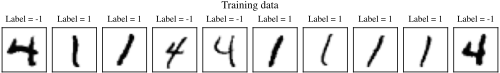

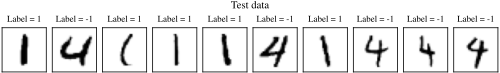

In [6]:
def show_mnist_img(ax, img, title=""):
    """Show a single MNIST image in `ax`."""
    
    ax.imshow(img.reshape(28, 28), cmap="Greys")
    ax.set_title(title)
    
    # Remove ticks and labels
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
def show_n_mnist_imgs(X_data, y_data, title, n=10):
    """Show the first `n` images from `X_data` with the labels."""
    n = min(n, X_data.shape[0])
    
    fig, axs = plt.subplots(1, n, figsize=(n * 0.7, 1.2))
    for idx in range(n):
        title_img = f"Label = {y_data[idx]}"
        show_mnist_img(axs[idx], X_data[idx, :], title_img)
    fig.suptitle(title)
    plt.show()
    
show_n_mnist_imgs(X_train, y_train, "Training data")
print("")
show_n_mnist_imgs(X_test, y_test, "Test data")

### 2. Loss Function

The first step in GP classification is finding the mode $\hat{f_X}$ of the posterior, i.e. 

\begin{align*}
\hat{f_X}
&= \text{argmax}_{f_X} p(f_X | X, y) \\
&= \text{argmin}_{f_X} \mathcal{L}(f_X), 
\end{align*}

where $\mathcal{L}(f_X) := - [\log(p(y | f_X)) + \log(p(f_X | X))]$ denotes the loss-function. We thus need to define the log-prior $\log(p(f_X | X))$ and the log-likelihood $\log(p(y | f_X))$. In order to solve the optimization problem, we will also need access to the gradients of these functions. In the theory exercises (a) and (b), your task is to give a derivation for the quantities given below.

**Log-prior:** The prior $p(f | X)$ is simply the GP prior (with mean function $m$ and covariance function $k$) on the latent function evaluated at $X$. So, it is a Gaussian $p(f_X | X) = \mathcal{N}(f; m(X), k(X, X))$. The log-density is therefore given by the quadratic

$$
\log(p(f_X | X)) 
= 
- \frac{1}{2} (f_X - m(X))^\top k(X, X)^{-1} (f_X - m(X))
- \frac{1}{2} \vert k(X, X) \vert
- \frac{N}{2} \log(2 \pi).
$$

Its gradient with respect to $f_X$ is given by $- k(X, X)^{-1} (f_X - m(X))$. 

In [7]:
import functools

def constant_mean(x, c=0.0):
    return c * jnp.ones_like(x[:, 0])

def RQ_kernel(a, b, theta=1.0, ell=1.0, alpha=1.0):
    return theta**2 * (1 + jnp.sum((a - b) ** 2, axis=-1) / (2 * alpha * ell**2) )**(-alpha)

# Define prior GP for f
mean = functools.partial(constant_mean, c=0.0)
kernel = functools.partial(RQ_kernel, theta=10, ell=17)
prior_GP = gaussians.GaussianProcess(mean, kernel)

**Task:** Complete the `val` and `grad` methods below. Sample an example input `fX_example` and test your `grad` method against the log-prior's gradient computed via autodiff. 

In [8]:
class LogPrior:
    """Log-prior log(p(f_X | X)) based on a GP prior on f."""

    def __init__(self, prior_GP, X):
        self.prior_gaussian = prior_GP(X)  # Evaluate the GP on `X`
        

    def val(self, fX):
        """Return log(p(f_X | X)) evaluated at `fX`."""

        # TODO
        kXX = self.prior_gaussian.Sigma
        mX = self.prior_gaussian.mu
        return 0.5 * (
            -(fX - mX).T @ jnp.linalg.solve(kXX, fX - mX) 
            - jnp.linalg.slogdet(kXX)[1]
            - len(mX) * jnp.log(2 * jnp.pi)
        )

    def grad(self, fX):
        """Return the gradient of log(p(f_X | X)) evaluated at `fX`."""
        kXX = self.prior_gaussian.Sigma
        mX = self.prior_gaussian.mu
        return -jnp.linalg.solve(kXX, jnp.eye(len(kXX))) @ (fX - mX)

In [9]:
# Sample an example input `fX_example`
key = jax.random.PRNGKey(0) 
key, subkey = jax.random.split(key)  
# just sample from a multivariate gaussian of the correct shape 
# with mean zero and covariance identity
size = prior_GP(X_train).mu.shape[0]
mean_t = np.zeros(size)
cov = np.eye(size)
fX_example = jax.random.multivariate_normal(subkey, mean_t, cov)


# Create the log-prior
log_prior = LogPrior(prior_GP, X_train)

# Test against autodiff
manual = log_prior.grad(fX_example)
autodiff = jax.grad(log_prior.val)(fX_example)
print(f"The result of comparing manual and autodiff is {jnp.allclose(manual, autodiff)}")


The result of comparing manual and autodiff is True


**Log-likelihood:** Next, we define the log-likelihood $\log(p(y | f_X))$ and its gradient. Let $\sigma(z) := 1 / (1 + \exp(-z))$ denote the logistic function. It holds:

$$
\log(p(y | f_X)) 
= \sum_{i=1}^N -\log(1 + \exp(-y_i \cdot f(x_i))).
$$

The gradient of $\log(p(y | f_X))$ with respect to $f_X$ is given by $\nabla\log(p(y | f_X)) = t - \pi$, where $t = (y + 1) / 2$ and $\pi = \sigma(f_X)$ (applied element-wise).

**Task:** Complete the `val` and `grad` methods below. Again, test the gradient at `fX_example` against the gradient computed via autodiff.

In [10]:
def logistic_func(z):
    return 1.0 / (1.0 + jnp.exp(-z))


class LogLikelihood:
    """Log-likelihood log(p(y | f_X))."""
    def __init__(self, y_signed):
        self.y_signed = y_signed  # fixed
    
    def val(self, fX):
        """Return log(p(y | f_X)) evaluated at `fX`."""
        return jnp.sum(jax.nn.log_sigmoid(self.y_signed * fX)) 
    
    def grad(self, fX):
        """Return the gradient of log(p(y | f_X)) evaluated at `fX`."""
        t = (self.y_signed + 1) / 2
        pi = logistic_func(fX)
        return t - pi

In [11]:
# Create the log-likelihood
log_likelihood = LogLikelihood(y_train)

# Test against autodiff
manual = log_likelihood.grad(fX_example)
autodiff = jax.grad(log_likelihood.val)(fX_example)

print(f"The result of comparing manual and autodiff is {jnp.allclose(manual, autodiff)}")

The result of comparing manual and autodiff is True


**Loss function:** Now, we can finally define the loss-function $\mathcal{L}(f_X) = - [\log(p(y | f_X)) + \log(p(f_X | X))]$. 

**Task:** Complete the function below. Again, test the gradient at `fX_example` against the gradient computed via autodiff.

In [63]:
@jax.jit  # We want this to be fast
def loss_val_and_grad(fX):
    """Return the value and gradient of the loss function at `fX`."""

    val = -(log_likelihood.val(fX) + log_prior.val(fX))
    grad =  -(log_likelihood.grad(fX) + log_prior.grad(fX))
    return val, grad

In [64]:
# Test against autodiff
_ , manual = loss_val_and_grad(fX_example)
autodiff = -log_prior.grad(fX_example) - log_likelihood.grad(fX_example)

print(f"The result of comparing manual and autodiff is {jnp.allclose(manual, autodiff)}")

The result of comparing manual and autodiff is True


### 3. Optimization with Gradient Descent

Now, that we can evaluate the loss-function and its gradient, we can implement gradient descent in order to find the *minimizer* $\hat{f_X}$ of $\mathcal{L}$ (which *maximizes* the posterior). For this, we initialize `fX` at zero and iteratively perform updates $f_X \gets f_X - \alpha \nabla\mathcal{L}(f)$ with some learning rate $\alpha > 0$. 

**Task:** Complete the training loop below. For each iteration, store the loss value in `losses_list` and perform the gradient descent update. Visualize the training process: Plot the loss values (on the $y$-axis) over the iterations (on the $x$-axis).

In [ ]:
import tqdm 


# Optimization parameters
num_steps = 20_000
alpha = 0.1

losses_list = []
fX = jnp.zeros_like(y_train)

@jax.jit
def update(fX, alpha):
    val , gradient = loss_val_and_grad(fX)
    fX = fX - alpha * gradient
    return fX, val



for step_idx in tqdm.trange(num_steps, position=0, leave = True):
    fX, val = update(fX, alpha)
    losses_list.append(val)

# Store final `f` in `fX_hat`
fX_hat = fX





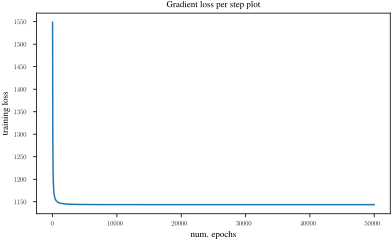

In [181]:
# Visualization of training process
plt.plot(jnp.arange(len(losses_list))), losses_list)
plt.title("Gradient loss per step plot")
plt.xlabel("num. epochs")
plt.ylabel("training loss")
plt.show()

### 4. Posterior GP

The posterior mean and covariance function are given by

\begin{align}
\hat{m}(x_*) 
&= m(x_*) + k(x_*, X) \cdot \nabla \log(p(y | \hat{f_X})) \\
\hat{k}(a, b)
&= k(a, b) - k(a, X)^T (k(X, X) + W^{-1})^{-1} k(X, b),
\end{align}
where $W$ is a diagonal matrix with $\text{diag}(W) = \pi \odot (1 - \pi)$ ($\odot$ denotes the element-wise product of two vectors) and $\pi = \sigma(\hat{f_X})$.

**Task:** Implement the posterior mean and covariance functions. For evaluating the posterior covariance, compute the Cholesky factorization of $k(X, X) + W^{-1}$ only once. 

In [164]:
def posterior_mean(x):
    """Posterior mean function as defined above"""
    return prior_GP.m(x) + prior_GP.k(
        x[:, None, :], X_train[None, :, :]
    ) @ log_likelihood.grad(fX_hat)


def posterior_covar(a, b):
    """Posterior covariance function as defined above"""
    pi = logistic_func(fX_hat)
    W_inv = jnp.diag(1 / (pi * (1 - pi)))

    cho = jax.scipy.linalg.cho_factor(
        prior_GP.k(X_train[:, None, :], X_train[None, :, :]) + W_inv
    )

    mat = jax.scipy.linalg.cho_solve(cho, prior_GP.k(X_train[:, None, :], b))

    return prior_GP.k(a, b) - prior_GP.k(a, X_train[None, :, :]) @ mat

**Posterior GP:** Now, we can construct the posterior GP.

In [165]:
post_GP = gaussians.GaussianProcess(posterior_mean, posterior_covar)

### 5. Further analyses

In the following, we will use the posterior GP for further analyses. 

By evaluating the posterior GP on some data $x_*$, we obtain a Gaussian $p(f_*) = \mathcal{N}(f_*; \hat{m}(x_*), \hat{k}(x_*, x_*))$. The predictive probability for the positive class (the digit 1) is given by

$$
\mathbb{E}_{p(f_*)}[\sigma(f_*)] = \int_{f_*} \sigma(f_*) \cdot p(f_*) df_*
$$

We consider two approaches: 
1. We can approximate the predictive probability by $\mathbb{E}_{p(f_*)}[\sigma(f_*)] \approx \sigma(\hat{m}(x_*))$, i.e. by mapping the mean of the Gaussian through the logistic function. 
2. Another approximation (developed by David JC MacKay, 1992) is given by 

$$
\mathbb{E}_{p(f_*)}[\sigma(f_*)] \approx \sigma\big(\frac{\hat{m}(x_*)}{\sqrt{1 + \frac{\pi}{8} \hat{k}(x_*, x_*)}}\big).
$$

**Task:** Complete `predictive_probs_2` below. Use approach 2 to compute the predicitive probabilities for the training and test data.

In [166]:
def predictive_probs_1(gaussian):
    """Predictive probabilities from a given Gaussian `gaussian` based 
    on approach 1 above"""
    
    return logistic_func(gaussian.mu)

def predictive_probs_2(gaussian):
    """Predictive probabilities from a given Gaussian `gaussian` based 
    on approach 2 above"""

    #return logistic_func(gaussian.mu)/jnp.sqrt(1 + 0.125 * jnp.pi * jnp.diag(gaussian.Sigma))
    return logistic_func(gaussian.mu/jnp.sqrt(1+(jnp.pi/8)*jnp.diag(gaussian.Sigma)))


# Evaluate the posterior GP on the training and test data
post_gaussian_train = post_GP(X_train)
post_gaussian_test = post_GP(X_test)

# Compute the predictive probabilities using approach 2
probs_train = predictive_probs_2(post_gaussian_train)
probs_test = predictive_probs_2(post_gaussian_test)


Next, we can use the predictive probabilities to compute confidences for the training and test data points. The confidence is given by the maximum of the probabilities over all classes. 

In [167]:
# Confidence
confs_train = np.maximum(probs_train, 1 - probs_train)
confs_test = np.maximum(probs_test, 1 - probs_test)

With those confidence vectors, we can determine the $k$ most/least certain digits.

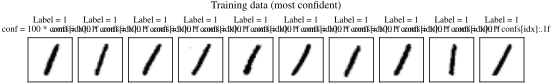

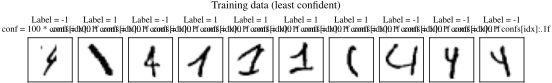

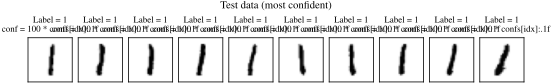

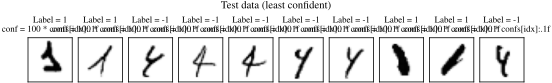

In [169]:
def show_k_most_least_confident(X_data, y_data, title, confs, k=5):
    """Plot the `k` most/least certain data points."""
    
    sorted_indides = np.argsort(confs)
    indices_most = sorted_indides[-k:]  # last k indices
    indices_least = sorted_indides[:k]  # first k indices
    
    # Set upo figures for most and least confident data points
    fig_most, axs_most = plt.subplots(1, k, figsize=(k * 0.7, 1.5))
    fig_least, axs_least = plt.subplots(1, k, figsize=(k * 0.7, 1.5))
    
    for axs, indices in zip([axs_most, axs_least], [indices_most, indices_least]):
        for ax_idx, idx in enumerate(indices):
            title_img = f"Label = {y_data[idx]}\n conf = 100 * confs[idx]:.1f %"
            show_mnist_img(axs[ax_idx], X_data[idx, :], title_img)
    
    fig_most.suptitle(title + " (most confident)")
    fig_least.suptitle(title + " (least confident)")    
    plt.show()
    
show_k_most_least_confident(X_train, y_train, "Training data", confs_train, k=10)
print("")
show_k_most_least_confident(X_test, y_test, "Test data", confs_test, k=10)

We can also use the confidence vectors to make predictions. 

In [170]:
def predict_y(probs):
    """Compute the predicted class based on the probabilities for the 
    positive class."""
    y_pred = np.zeros_like(probs).astype(int)
    y_pred[probs >= 0.5] = 1
    y_pred[probs < 0.5] = -1
    return y_pred

y_pred_train = predict_y(probs_train)
y_pred_test = predict_y(probs_test)

By comparing the predicted classes to the ground truth (`y_train` and `y_test`), we can compute accuracies on both data sets. 

**Task:** Compute and print the training and test accuracy. *Hint*: If everything works correctly you should achieve a training accuracy of 100% and a test accuracy of 99.67%.

(Training was taking an extremely long time even with `@jit`)

In [171]:
# TODO
total_train = len(y_train)
total_test = len(y_test)
acc_train = np.sum(y_pred_train == y_train)/total_train
acc_test = np.sum(y_pred_test == y_test)/total_test
acc_train, acc_test

(1.0, 0.9966666666666667)

We can use the function below to show the misclassified data points.

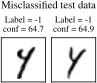

In [172]:
def show_misclassified_imgs(X_data, y_data, y_pred, confs, title):
    
    mis_indices = list((y_pred != y_data).nonzero()[0])
    num_mis = len(mis_indices)
    if num_mis == 0:
        return  # Return if no misclassifications
    
    fig, axs = plt.subplots(1, num_mis, figsize=(num_mis * 0.7, 1.5))
    for idx, mis_idx in enumerate(mis_indices):
        title_img = f"Label = {y_data[mis_idx]}\n conf = {100 * confs[mis_idx]:.1f} %"
        show_mnist_img(axs[idx], X_data[mis_idx, :], title_img)
    fig.suptitle(title)
    plt.show()

# Plot misclassified test data points
show_misclassified_imgs(X_train, y_train, y_pred_train, confs_train, "Misclassified training data")
print("")
show_misclassified_imgs(X_test, y_test, y_pred_test, confs_test, "Misclassified test data")

Finally, let's compare the two approaches for the predictive probabilities on out-of-distribution data. 

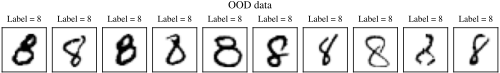


OOD data:
X.shape =  (100, 784)
X in range [-1.0, 1.0]
y.shape =  (100,)
Target yi = 8: Found 100 times


In [173]:
# Load/show the data
X_ood, y_ood = data["X_ood"], data["y_ood"]
show_n_mnist_imgs(X_ood, y_ood, "OOD data", n=10)
print_data_info(X_ood, y_ood, "OOD data")

In [174]:
# Evaluate the posterior GP on `X_ood`, compute predicted probabilities
post_gaussian_ood = post_GP(X_ood)
probs_ood_1 = predictive_probs_1(post_gaussian_ood)
probs_ood_2 = predictive_probs_2(post_gaussian_ood)

# Compute confidences
confs_ood_1 = np.maximum(probs_ood_1, 1 - probs_ood_1)
confs_ood_2 = np.maximum(probs_ood_2, 1 - probs_ood_2)

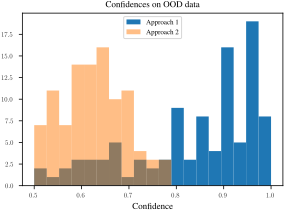

In [175]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
bins = np.linspace(0.5, 1, 20)

ax.hist(confs_ood_1, bins=bins, alpha=1.0, label="Approach 1")
ax.hist(confs_ood_2, bins=bins, alpha=0.5, label="Approach 2")

# General settings
ax.set_title("Confidences on OOD data")
ax.set_xlabel("Confidence")
ax.legend(loc="upper center")
plt.show()

**Task:** How can the difference between the two histograms be explained? Which of the two approaches would you prefer? Explain your decision briefly. 

**Your answer:**
The second approach is much less confident about the prediction on our out of distribution data than the first. The second approach would be our choice since it seems unreasonable to ascribe such a high degree of confidence to classification of data that, by its very nature, shouldn't have a clear classification. 